In [1]:
import numpy as np
import os
import pyedflib
import json
import sklearn
import matplotlib
import mne

In [2]:
file = "data/eeg-24-05-23_17-03.edf"
loaded_data = mne.io.read_raw_edf(file)
loaded_data.load_data()

Extracting EDF parameters from C:\Users\Ilya\Documents\GitHub\EEG_feedback\EEG_preprocessing\data\eeg-24-05-23_17-03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 190874  =      0.000 ...  1526.992 secs...


<RawEDF | eeg-24-05-23_17-03.edf, 8 x 190875 (1527.0 s), ~11.7 MB, data loaded>

In [3]:
events = mne.events_from_annotations(loaded_data)
arr_events = events[0]
arr_events

Used Annotations descriptions: ['end task', 'fake wrong answer', 'right answer', 'start task']


array([[     1,      0,      4],
       [ 30760,      0,      2],
       [ 30925,      0,      1],
       [ 30925,      0,      4],
       [ 62368,      0,      2],
       [ 62524,      0,      1],
       [ 62524,      0,      4],
       [ 97123,      0,      3],
       [ 97333,      0,      1],
       [ 97333,      0,      4],
       [113761,      0,      3],
       [113926,      0,      1],
       [113926,      0,      4],
       [148156,      0,      3],
       [148327,      0,      1],
       [148327,      0,      4],
       [179641,      0,      3],
       [180052,      0,      1],
       [180052,      0,      4],
       [190804,      0,      3],
       [190804,      0,      1],
       [190804,      0,      4]])

In [4]:
arr_events.shape

(22, 3)

In [5]:
filtered_data = loaded_data.copy().filter(l_freq=None, h_freq=40., fir_design='firwin', method='iir', iir_params=None)
filtered_data = filtered_data.copy().filter(l_freq=2.,h_freq=None, fir_design='firwin', method='iir', iir_params=None)

raw_data = filtered_data.get_data()

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB



In [6]:
filtered_data.info

<Info | 7 non-empty values
 bads: []
 ch_names: O1, P3, C3, F3, F4, C4, P4, O2
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 2.0 Hz
 lowpass: 40.0 Hz
 meas_date: 2023-05-24 17:03:51 UTC
 nchan: 8
 projs: []
 sfreq: 125.0 Hz
>

Using matplotlib as 2D backend.


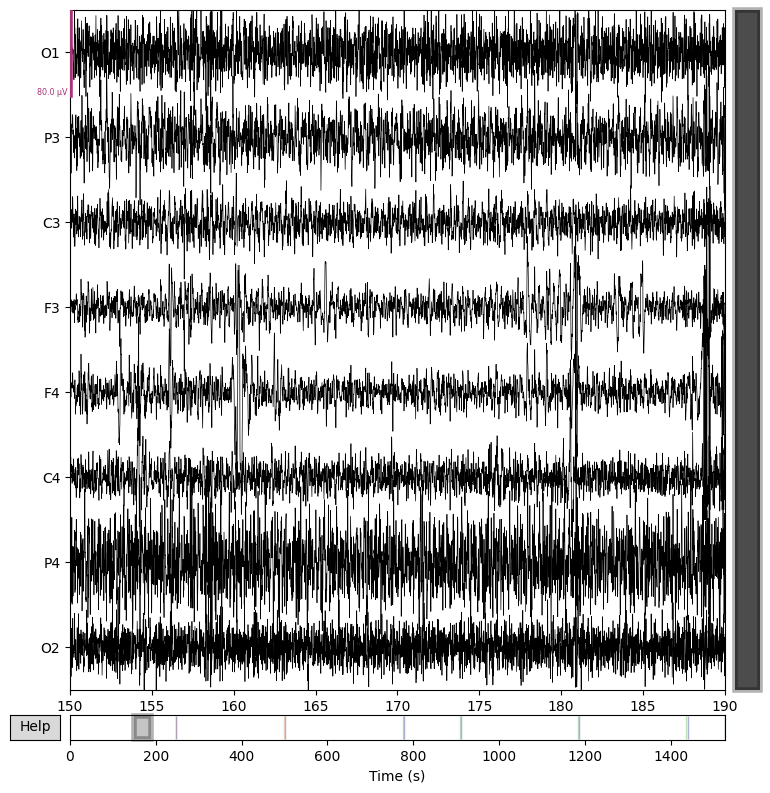

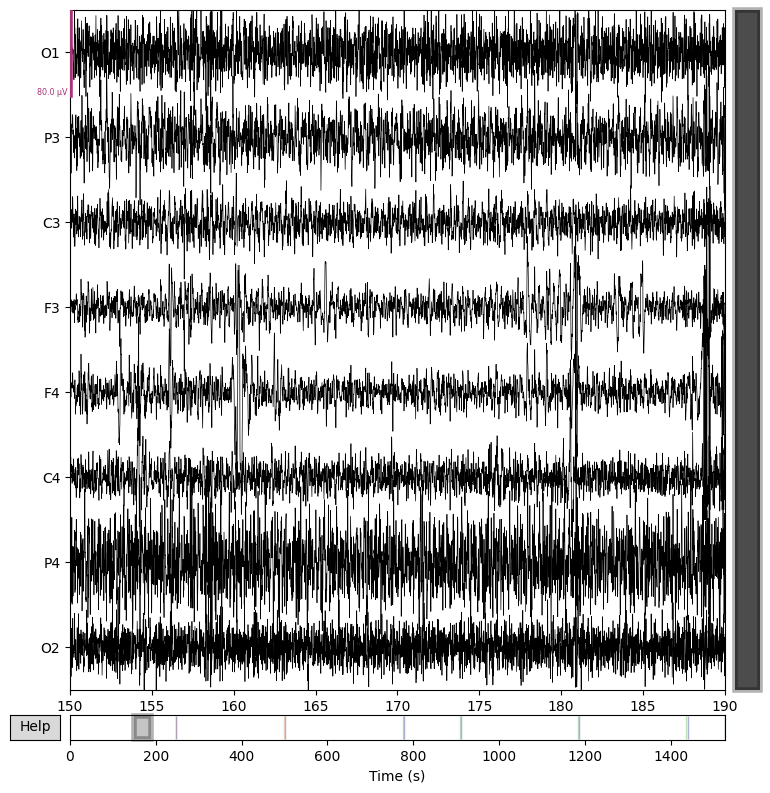

In [7]:
filtered_data.plot(start=150, duration=40, proj=False, n_channels=len(filtered_data.ch_names), remove_dc=False, scalings=40e-6)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.384 (s)


C:\Users\Ilya\AppData\Local\Temp\ipykernel_11320\3296019125.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered_data.plot_psd(area_mode='range', tmax=1200.0, picks='data', average=False)
C:\Users\Ilya\Documents\GitHub\EEG_feedback\EEG_testing\env\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


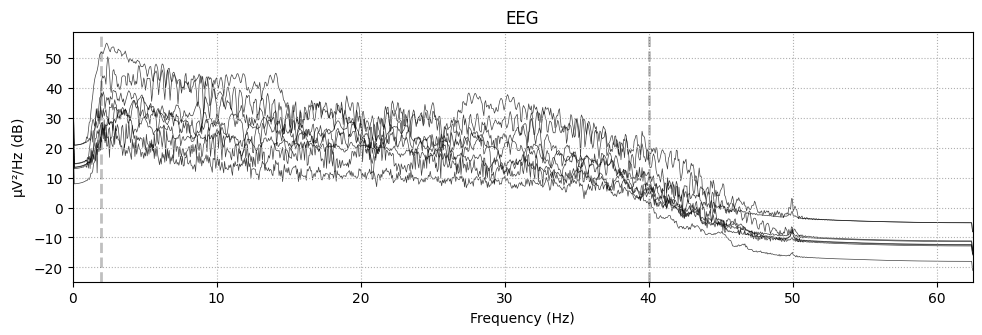

In [8]:
picks = mne.pick_types(filtered_data.info, meg='mag', eeg=True, eog=False, stim=False, exclude='bads')
filtered_data.plot_psd(area_mode='range', tmax=1200.0, picks='data', average=False)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.384 (s)


C:\Users\Ilya\AppData\Local\Temp\ipykernel_11320\1547064175.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  loaded_data.plot_psd(area_mode='range', tmax=40.0, picks='data', average=False)
C:\Users\Ilya\Documents\GitHub\EEG_feedback\EEG_testing\env\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


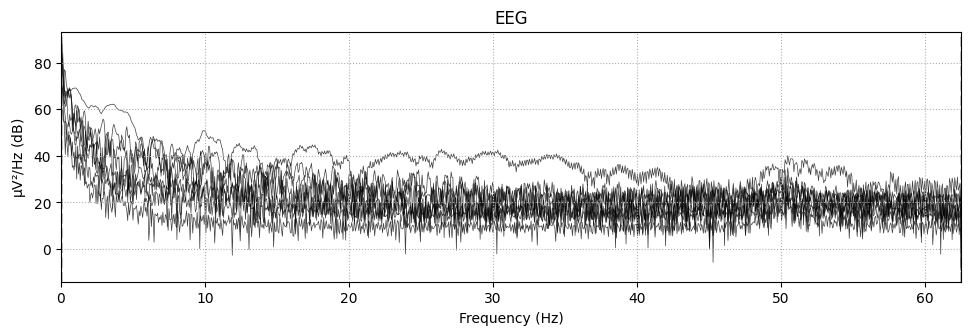

In [9]:
loaded_data.plot_psd(area_mode='range', tmax=40.0, picks='data', average=False)

In [10]:
ans_data = np.zeros((1,8,165))
marks = []
for i in range(arr_events.shape[0]-4):
    if (arr_events[i,2] == 2) or (arr_events[i,2] == 3):
        ans = raw_data[:,arr_events[i,0]:(arr_events[i,0]+165)]
        ans = ans.reshape(1,ans.shape[0],ans.shape[1])
        ans_data = np.concatenate((ans_data, ans), axis=0)
        marks.append(arr_events[i,2]-2)
        
ans_data = ans_data[1:,:,:]
print(ans_data.shape)

(6, 8, 165)


In [11]:
X = ans_data.copy()
X.shape

(6, 8, 165)

In [12]:
Y = np.array(marks)
Y.shape

(6,)

In [14]:
from sklearn.model_selection import train_test_split
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4, 1320) (2, 1320) (4,) (2,)


In [15]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer().fit(x_train)
stand_x_train = scaler.transform(x_train)
scaler = Normalizer().fit(x_test)
stand_x_test = scaler.transform(x_test)
stand_x_test

array([[ 0.01381141,  0.0080356 ,  0.0024506 , ...,  0.00513701,
        -0.00328882, -0.00718541],
       [-0.00128062, -0.00791346, -0.04249903, ..., -0.05195689,
         0.01387797,  0.02738478]])

In [16]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors = 3)
knn.fit(stand_x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
data_dir = Path("data")
for file in data_dir.iterdir():
    if file.suffix == ".edf":
        